# 1. Weather forecasting using SARIMAX

In [1]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [5]:
weather = pd.read_csv("thai binh 2002-2022.csv", on_bad_lines='skip')
weather

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,thai binh,1/31/2002,17.3,14.6,15.7,17.3,14.6,15.7,13.0,84.3,...,NaN,NaN,NaN,2002-01-31T06:31:16,2002-01-31T17:44:59,0.58,"Rain, Overcast",Cloudy skies throughout the day with late afte...,rain,"4,882,309,999,948,820,000,000"
1,thai binh,2/1/2002,14.9,11.6,12.7,14.9,11.6,12.7,11.3,91.5,...,NaN,NaN,NaN,2002-02-01T06:30:58,2002-02-01T17:45:35,0.61,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"4,882,309,999,948,820,000,000"
2,thai binh,2/2/2002,12.6,11.4,12.0,12.6,11.4,12.0,8.4,78.7,...,NaN,NaN,NaN,2002-02-02T06:30:38,2002-02-02T17:46:11,0.65,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"4,882,309,999,948,820,000,000"
3,thai binh,2/3/2002,15.3,11.5,13.3,15.3,11.5,13.3,10.9,85.9,...,NaN,NaN,NaN,2002-02-03T06:30:17,2002-02-03T17:46:47,0.68,"Rain, Overcast",Cloudy skies throughout the day with afternoon...,rain,"4,882,309,999,948,820,000,000"
4,thai binh,2/4/2002,15.5,13.5,14.2,15.5,13.5,14.2,13.8,97.7,...,NaN,NaN,NaN,2002-02-04T06:29:55,2002-02-04T17:47:22,0.75,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"4,882,309,999,948,820,000,000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7635,thai binh,12/27/2022,23.1,17.2,19.8,23.1,17.2,19.8,14.6,72.9,...,8.7,5.0,10.0,2022-12-27T06:28:39,2022-12-27T17:22:27,0.13,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"488,251,999,994,882,000,000,000,000,000,000"
7636,thai binh,12/28/2022,21.1,13.3,17.5,21.1,13.3,17.5,12.3,72.4,...,2.9,2.0,10.0,2022-12-28T06:29:04,2022-12-28T17:23:02,0.16,"Rain, Overcast",Cloudy skies throughout the day with afternoon...,rain,"488,251,999,994,882,000,000,000,000,000,000"
7637,thai binh,12/29/2022,18.1,12.4,15.0,18.1,12.4,15.0,8.0,63.4,...,8.9,6.0,10.0,2022-12-29T06:29:28,2022-12-29T17:23:37,0.20,"Rain, Overcast",Cloudy skies throughout the day with late afte...,rain,"488,251,999,994,882,000,000,000,000,000,000"
7638,thai binh,12/30/2022,18.1,13.1,14.7,18.1,13.1,14.7,7.9,63.7,...,14.1,7.0,10.0,2022-12-30T06:29:50,2022-12-30T17:24:12,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"488,251,999,994,882,000,000,000,000,000,000"


In [6]:
weather = weather[['datetime','temp', 'humidity', 'precip']]
weather = weather.dropna(subset=['temp'])
weather.dtypes

,0
datetime,object
temp,float64
humidity,float64
precip,float64


In [7]:
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.rename(columns={'temp': 'temperature', 'datetime': 'date'})
weather = weather.resample('M', on='date').mean()
weather.reset_index(inplace=True)
weather.head(2)

,date,temperature,humidity,precip
0,2002-01-31,15.70,84.300000,0.076000
1,2002-02-28,18.65,90.771429,0.981179


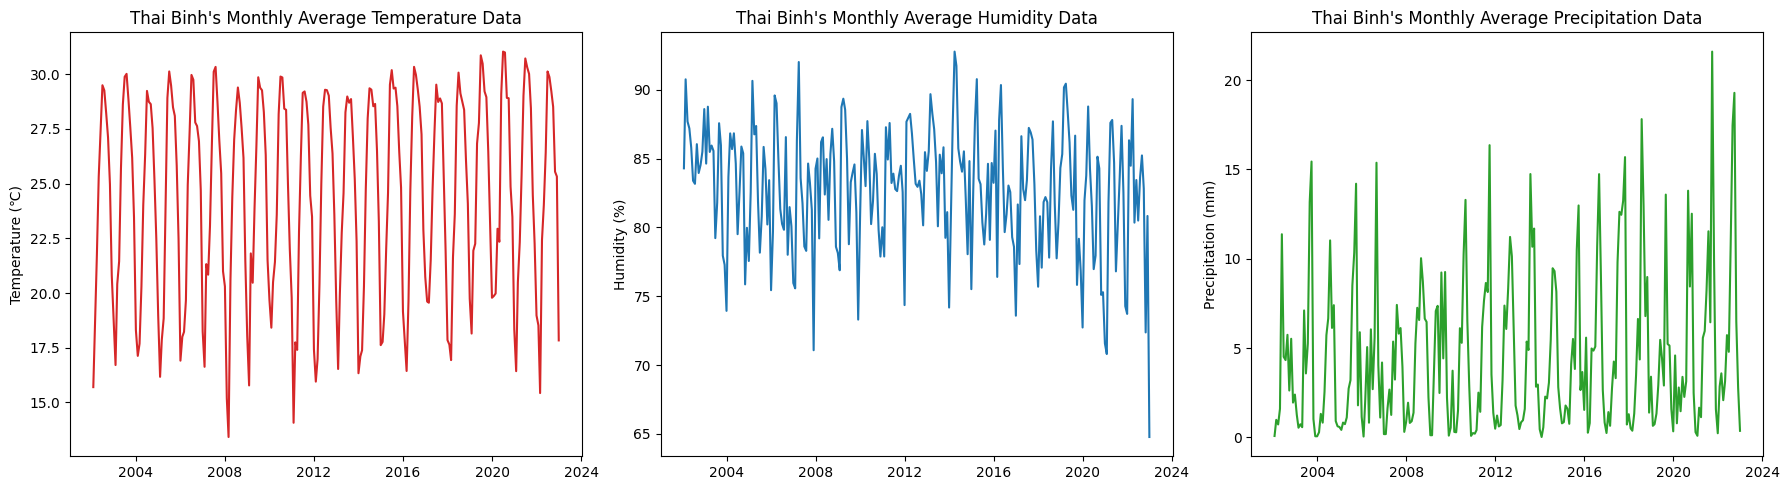

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Create a figure with 1 row and 3 columns of subplots

# Plot temperature data
axs[0].plot(weather.set_index('date')['temperature'], color='tab:red')
axs[0].set_ylabel('Temperature (℃)')
axs[0].set_title("Thai Binh's Monthly Average Temperature Data")

# Plot humidity data
axs[1].plot(weather.set_index('date')['humidity'], color='tab:blue')
axs[1].set_ylabel('Humidity (%)')
axs[1].set_title("Thai Binh's Monthly Average Humidity Data")

# Plot precipitation data
axs[2].plot(weather.set_index('date')['precip'], color='tab:green')
axs[2].set_ylabel('Precipitation (mm)')
axs[2].set_title("Thai Binh's Monthly Average Precipitation Data")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [9]:
weather.dtypes

,0
date,datetime64[ns]
temperature,float64
humidity,float64
precip,float64


In [10]:
import pandas as pd

weather_separated = {}  # Store pivoted DataFrames for each column
weather_linear = {}  # Store one-hot-encoded DataFrames for each column

# List of columns to process
columns_to_process = ['temperature', 'humidity', 'precip']

# Loop over each column and apply the transformations
for col in columns_to_process:
    # 1. Pivot Table: Separate by month and year
    df_copy = weather[['date', col]].copy(deep=True)
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['month'] = df_copy['date'].dt.month
    df_copy.drop(['date'], axis=1, inplace=True)

    pivoted = df_copy.pivot_table(index='month', columns='year', values=col)
    weather_separated[col] = pivoted  # Store pivoted DataFrame

    # 2. One-Hot Encoding: Create a linear model-friendly DataFrame
    linear_copy = weather[['date', col]].copy(deep=True)
    linear_copy['month'] = linear_copy['date'].dt.month

    # Apply one-hot encoding to the month column
    linear_encoded = pd.get_dummies(linear_copy, columns=['month'])
    weather_linear[col] = linear_encoded  # Store one-hot-encoded DataFrame





In [11]:
print("Pivoted Data for Temperature:")
print(weather_separated['temperature'])

print("\nOne-Hot Encoded Data for Temperature:")
print(weather_linear['temperature'].head())


Pivoted Data for Temperature:
year        2002       2003       2004       2005       2006       2007  \
month                                                                     
1      15.700000  16.709677  17.129032  16.170968  18.000000  16.629032   
2      18.650000  20.410714  17.686207  17.857143  18.225000  21.321429   
3      21.761290  21.448387  20.293548  18.841935  19.670968  20.838710   
4      25.320000  25.693333  24.023333  23.663333  24.941379  23.063333   
5      27.393548  28.612903  26.332258  28.912903  27.390323  26.777419   
6      29.496667  29.883333  29.236667  30.126667  29.967857  30.113333   
7      29.258065  30.016129  28.738710  29.477419  29.745161  30.335484   
8      28.200000  28.838710  28.632258  28.487097  27.796774  28.729032   
9      27.103333  27.576667  27.540000  28.093333  27.630000  26.976667   
10     24.974194  26.180645  25.148387  25.819355  26.938710  25.470968   
11     20.806667  23.463333  22.486667  22.486667  24.683333  20.99333

In [12]:
print("Pivoted Data for Precipitation:")
print(weather_separated['precip'])

print("\nOne-Hot Encoded Data for Precipitation:")
print(weather_linear['precip'].head())

Pivoted Data for Precipitation:
year        2002       2003       2004       2005       2006      2007  \
month                                                                    
1       0.076000   1.263484   0.285097   0.418194   0.045226  0.182516   
2       0.981179   0.539429   1.314103   0.826821   2.133857  1.623107   
3       0.721839   0.732194   0.823774   0.740387   5.053710  2.675258   
4       1.597267   0.568833   2.545833   1.112533   0.820828  1.256500   
5      11.371226   7.104806   5.723452   2.731419   6.046323  5.361839   
6       4.510700   3.578400   6.660067   3.196900   2.696536  3.236167   
7       4.325742   5.251516  11.026000   8.506452   5.590355  7.415258   
8       5.740484  13.167387   6.126226  10.349323  15.374161  5.805581   
9       2.621600  15.440700   7.399600  14.199233   4.047267  6.119467   
10      5.519161   1.025355   0.913516   1.792710   1.108097  3.947226   
11      1.947333   0.061567   0.620767   5.885067   4.189933  0.307067   
12    

In [13]:
print("Pivoted Data for Humidity:")
print(weather_separated['humidity'])

print("\nOne-Hot Encoded Data for Humidity:")
print(weather_linear['humidity'].head())

Pivoted Data for Humidity:
year        2002       2003       2004       2005       2006       2007  \
month                                                                     
1      84.300000  84.645161  83.667742  82.570968  79.677419  75.574194   
2      90.771429  88.782143  86.841379  90.660714  89.600000  86.367857   
3      87.706452  85.493548  85.700000  86.770968  89.029032  92.029032   
4      87.206667  85.956667  86.846667  87.380000  85.051724  83.593333   
5      85.793548  85.567742  84.638710  81.877419  81.345161  81.767742   
6      83.400000  79.226667  79.513333  78.170000  80.257143  78.623333   
7      83.174194  81.809677  82.567742  80.803226  79.835484  78.300000   
8      86.058065  87.580645  85.883871  85.858065  86.570968  84.648387   
9      83.963333  85.976667  85.393333  84.236667  78.016667  83.243333   
10     84.545161  77.951613  75.864516  80.219355  81.480645  81.290323   
11     85.510000  77.286667  79.976667  83.440000  80.090000  71.076667  

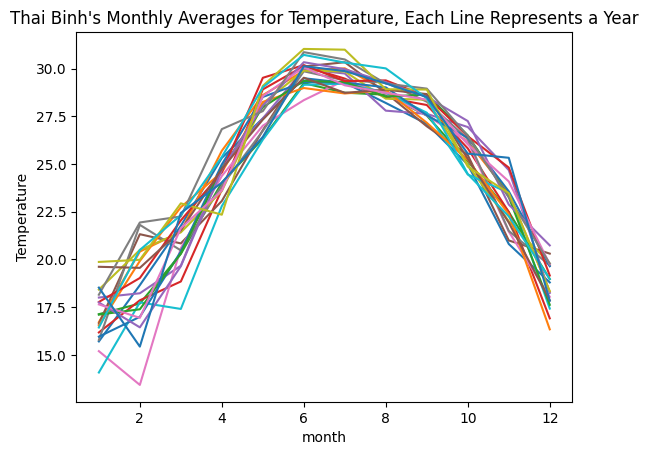

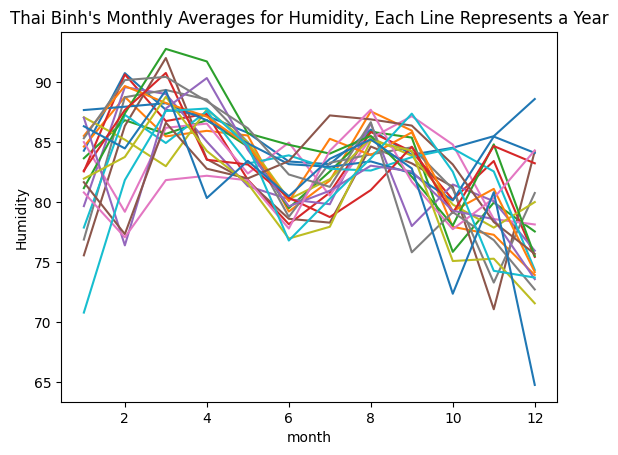

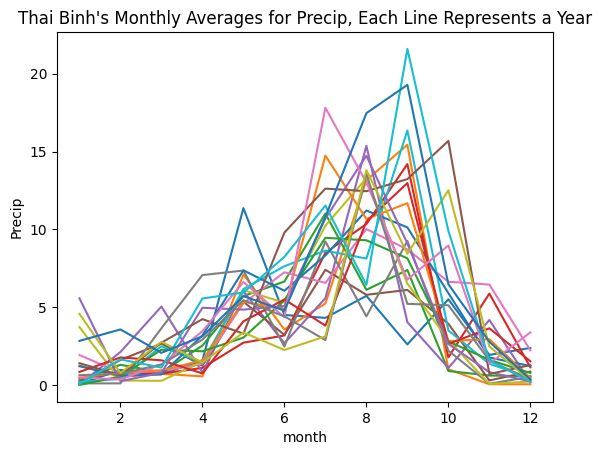

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# List of features to plot
features_to_plot = ['temperature', 'humidity', 'precip']

# Loop over each feature and plot the data
for feature in features_to_plot:
    weather_separated[feature].plot()  # Plot the pivoted DataFrame
    plt.ylabel(feature.capitalize())
    plt.title(f"Thai Binh's Monthly Averages for {feature.capitalize()}, Each Line Represents a Year")
    plt.legend().remove()  # Remove the legend for clarity
    plt.show()


In [15]:
def ad_fuller(timeseries):
    print ('Dickey-Fuller Test indicates ')
    df_test = adfuller(timeseries, regression='ct', autolag='AIC')
    output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print(output)
print('---------Temperature----------')
print(ad_fuller(weather['temperature']))
print('---------Humidity--------------')
print(ad_fuller(weather['humidity']))
print('---------Precip----------------')
print(ad_fuller(weather['precip']))


---------Temperature----------
Dickey-Fuller Test indicates 
Test Statistic                  -4.334419
p-value                          0.002780
#Lags Used                      15.000000
Number of Observations Used    236.000000
dtype: float64
None
---------Humidity--------------
Dickey-Fuller Test indicates 
Test Statistic                  -3.675509
p-value                          0.024022
#Lags Used                      14.000000
Number of Observations Used    237.000000
dtype: float64
None
---------Precip----------------
Dickey-Fuller Test indicates 
Test Statistic                  -3.235312
p-value                          0.077592
#Lags Used                      12.000000
Number of Observations Used    239.000000
dtype: float64
None


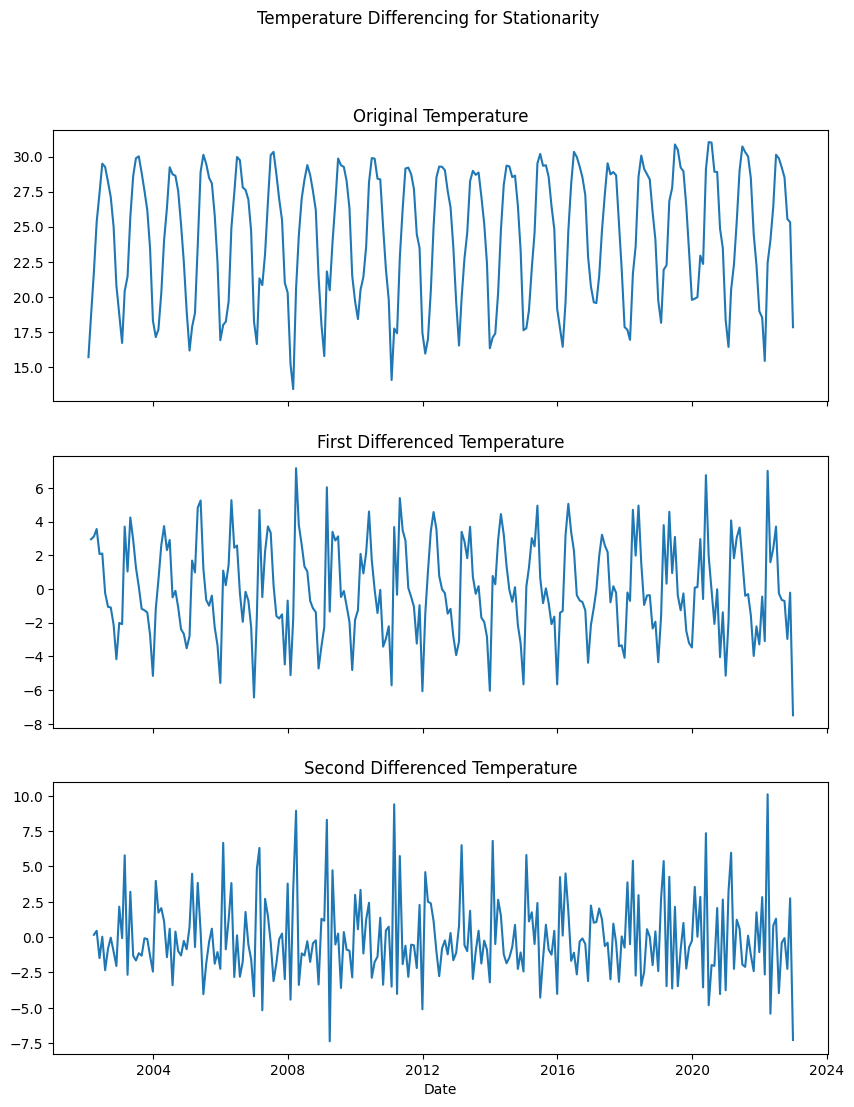

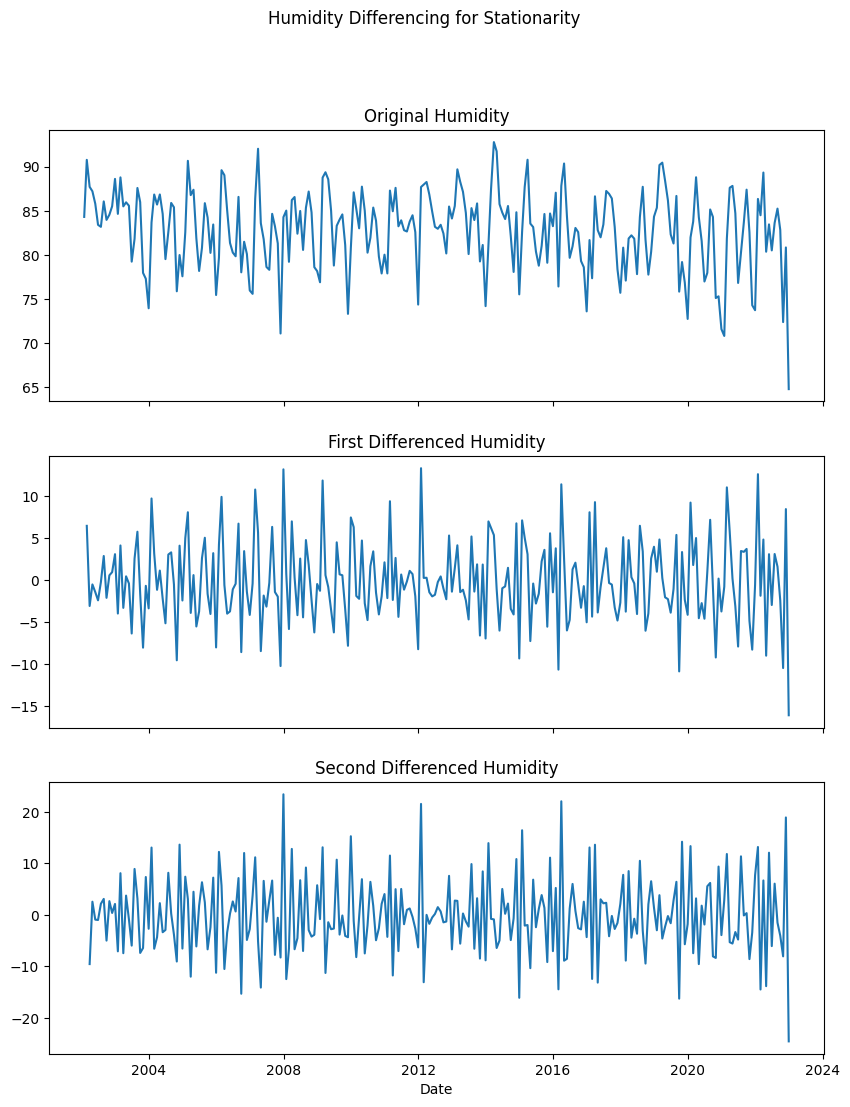

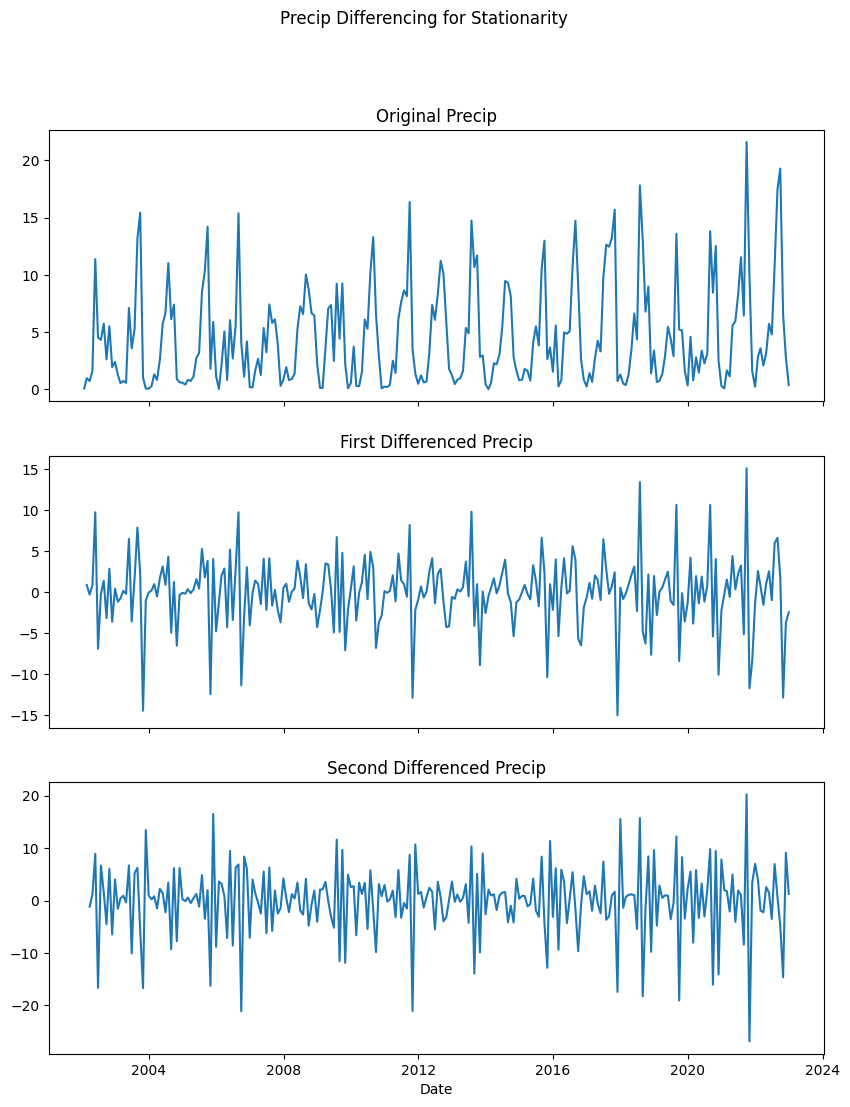

In [16]:
for feature in features_to_plot:
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    fig.suptitle(f'{feature.capitalize()} Differencing for Stationarity')

    # Original Series
    axes[0].plot(weather['date'], weather[feature])
    axes[0].set_title(f'Original {feature.capitalize()}')

    # First Difference
    first_diff = weather[feature].diff().dropna()
    axes[1].plot(weather['date'][1:], first_diff)
    axes[1].set_title(f'First Differenced {feature.capitalize()}')

    # Second Difference
    second_diff = first_diff.diff().dropna()
    axes[2].plot(weather['date'][2:], second_diff)
    axes[2].set_title(f'Second Differenced {feature.capitalize()}')

    plt.xlabel('Date')
    plt.show()

*   If the p-value of the original series is below 0.05, it’s already stationary, and
d=0
*   If the p-value of the first differenced series is below 0.05, then
d=1
*   If neither the original nor the first differenced series is stationary, try a second difference with d=2

In [17]:
from statsmodels.tsa.stattools import adfuller

for feature in features_to_plot:
    print(f"\nADF Test for {feature.capitalize()}:")

    # ADF Test on Original Series
    result = adfuller(weather[feature].dropna())
    print(f'Original: p-value = {result[1]:.5f}')

    # ADF Test on First Differenced Series
    first_diff = weather[feature].diff().dropna()
    result = adfuller(first_diff)
    print(f'First Difference: p-value = {result[1]:.5f}')

    # ADF Test on Second Differenced Series
    second_diff = first_diff.diff().dropna()
    result = adfuller(second_diff)
    print(f'Second Difference: p-value = {result[1]:.5f}')



ADF Test for Temperature:
Original: p-value = 0.01402
First Difference: p-value = 0.00000
Second Difference: p-value = 0.00000

ADF Test for Humidity:
Original: p-value = 0.01172
First Difference: p-value = 0.00000
Second Difference: p-value = 0.00000

ADF Test for Precip:
Original: p-value = 0.17418
First Difference: p-value = 0.00000
Second Difference: p-value = 0.00000


<Figure size 1000x600 with 0 Axes>

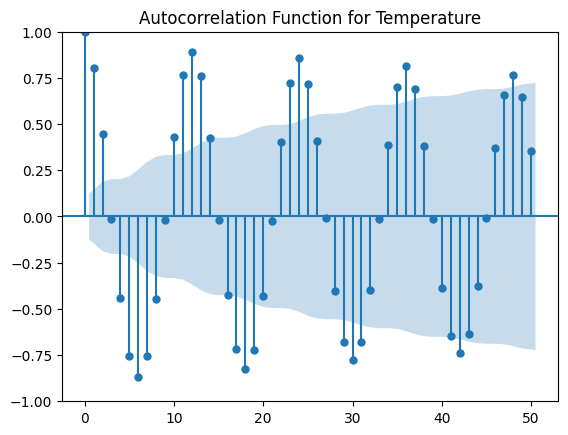

<Figure size 1000x600 with 0 Axes>

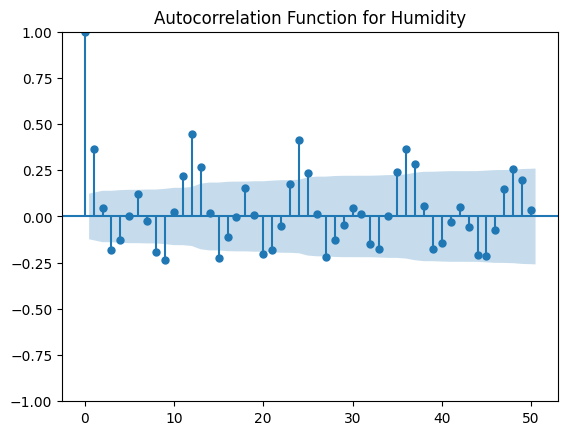

<Figure size 1000x600 with 0 Axes>

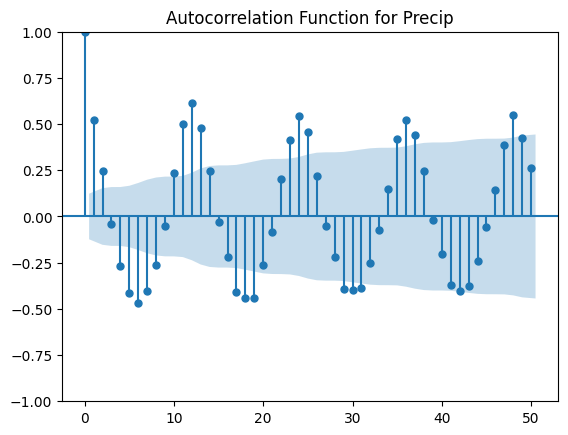

In [18]:
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    plot_acf(weather[feature], lags=50)  # ACF plot for the feature
    plt.title(f"Autocorrelation Function for {feature.capitalize()}")
    plt.show()

<Figure size 1000x600 with 0 Axes>

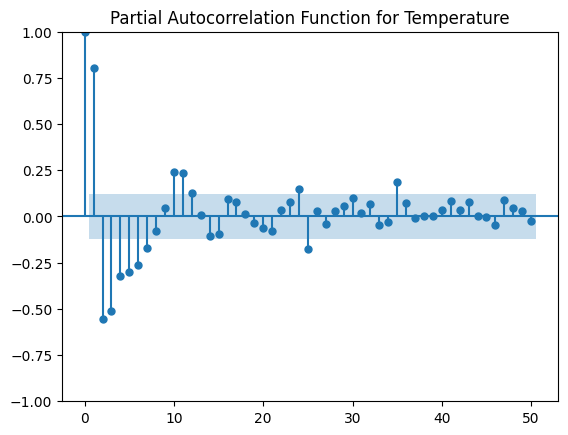

<Figure size 1000x600 with 0 Axes>

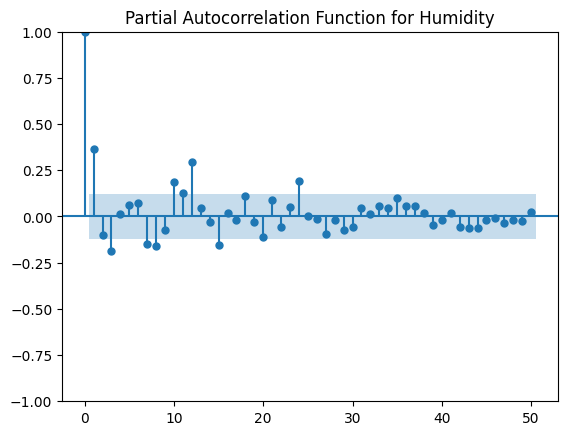

<Figure size 1000x600 with 0 Axes>

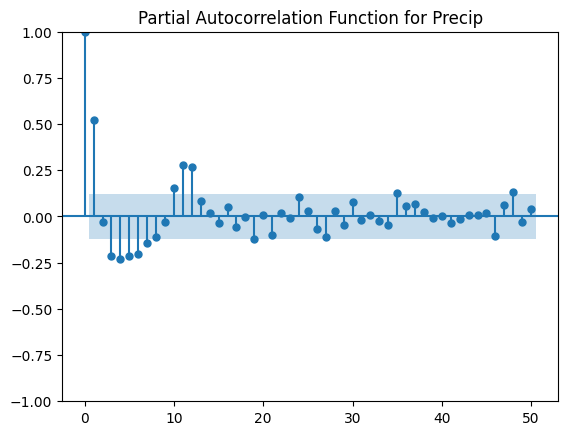

In [19]:
for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    plot_pacf(weather[feature], lags=50)  # ACF plot for the feature
    plt.title(f"Partial Autocorrelation Function for {feature.capitalize()}")
    plt.show()

In [20]:
train_data_SARIMA = weather[weather['date'] < '2015-01-31']
test_data_SARIMA = weather[weather['date'] >= '2015-01-31']
train_data_SARIMA.head(2)

,date,temperature,humidity,precip
0,2002-01-31,15.70,84.300000,0.076000
1,2002-02-28,18.65,90.771429,0.981179


In [21]:
import itertools
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

features_to_model = ['temperature', 'humidity', 'precip']

# Define ranges for p, d, q, and seasonal components
p_values = range(0, 3)
q_values = range(0, 3)
d_value = 1  # Assumed after stationarity check
seasonal_p_values = range(0, 2)
seasonal_q_values = range(0, 2)
seasonal_d_value = 1
seasonal_period = 12  # Assuming monthly seasonality

# Set train size as 80% of the data
train_size = int(len(weather) * 0.8)

# Dictionary to store best models and their parameters for each feature
best_models = {}

for feature in features_to_model:
    print(f"\nEvaluating SARIMAX models for {feature.capitalize()}:")

    best_aic = float("inf")
    best_bic = float("inf")
    best_rmse = float("inf")
    best_mae = float("inf")
    best_order = None
    best_seasonal_order = None
    best_model = None

    # Loop over combinations of p, d, q, and seasonal components
    for p, q, sp, sq in itertools.product(p_values, q_values, seasonal_p_values, seasonal_q_values):
        try:
            # Define the SARIMAX model
            model = sm.tsa.statespace.SARIMAX(
                weather[feature][:train_size],  # Train on the training set
                order=(p, d_value, q),
                seasonal_order=(sp, seasonal_d_value, sq, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            # Fit the model
            result = model.fit(disp=False)

            # Calculate metrics on the test set
            predictions = result.predict(start=train_size, end=len(weather[feature])-1)
            actual = weather[feature][train_size:]
            aic = result.aic
            bic = result.bic
            rmse = np.sqrt(mean_squared_error(actual, predictions))
            mae = mean_absolute_error(actual, predictions)

            print(f"SARIMAX({p},{d_value},{q}) x ({sp},{seasonal_d_value},{sq},{seasonal_period}) - AIC: {aic}, BIC: {bic}, RMSE: {rmse}, MAE: {mae}")

            # Update best model based on a chosen criterion (e.g., AIC here, but can be BIC, RMSE, etc.)
            if aic < best_aic:
                best_aic = aic
                best_bic = bic
                best_rmse = rmse
                best_mae = mae
                best_order = (p, d_value, q)
                best_seasonal_order = (sp, seasonal_d_value, sq, seasonal_period)
                best_model = result

        except Exception as e:
            print(f"SARIMAX({p},{d_value},{q}) x ({sp},{seasonal_d_value},{sq},{seasonal_period}) failed: {e}")
            continue

    best_models[feature] = {
        "model": best_model,
        "order": best_order,
        "seasonal_order": best_seasonal_order,
        "aic": best_aic,
        "bic": best_bic,
        "rmse": best_rmse,
        "mae": best_mae
    }

    print(f"\nBest SARIMAX model for {feature.capitalize()} - Order: {best_order}, Seasonal Order: {best_seasonal_order}")
    print(f"AIC: {best_aic}, BIC: {best_bic}, RMSE: {best_rmse}, MAE: {best_mae}")




Evaluating SARIMAX models for Temperature:
SARIMAX(0,1,0) x (0,1,0,12) - AIC: 795.1815912183422, BIC: 798.4126998351968, RMSE: 2.067642668580406, MAE: 1.7617489242554987
SARIMAX(0,1,0) x (0,1,1,12) - AIC: 633.2233575997964, BIC: 639.5529295476434, RMSE: 1.251072955180612, MAE: 0.9678757240249998
SARIMAX(0,1,0) x (1,1,0,12) - AIC: 660.7454180815695, BIC: 667.0863860716457, RMSE: 1.4894684373506557, MAE: 1.2632759109248781
SARIMAX(0,1,0) x (1,1,1,12) - AIC: 632.5301369194794, BIC: 642.02449484125, RMSE: 1.2417554720169988, MAE: 0.9777308376655389
SARIMAX(0,1,1) x (0,1,0,12) - AIC: 715.0828978657707, BIC: 721.5343912131972, RMSE: 1.903982390582514, MAE: 1.5919618637635995
SARIMAX(0,1,1) x (0,1,1,12) - AIC: 551.2670177014079, BIC: 560.7441835990514, RMSE: 1.3708108706848139, MAE: 1.1321631481329857
SARIMAX(0,1,1) x (1,1,0,12) - AIC: 609.5977718125071, BIC: 619.1092237976216, RMSE: 1.573748371078116, MAE: 1.333649299597252
SARIMAX(0,1,1) x (1,1,1,12) - AIC: 549.2115453255979, BIC: 561.8477


Fitting One-Step-Ahead SARIMAX Model for Temperature:


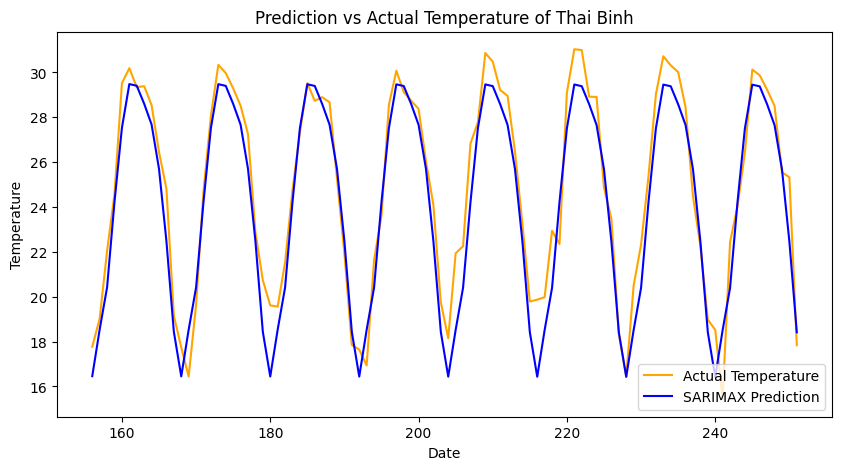

Results for Temperature saved to temperature_SARIMAX_predictions.csv

Fitting One-Step-Ahead SARIMAX Model for Humidity:


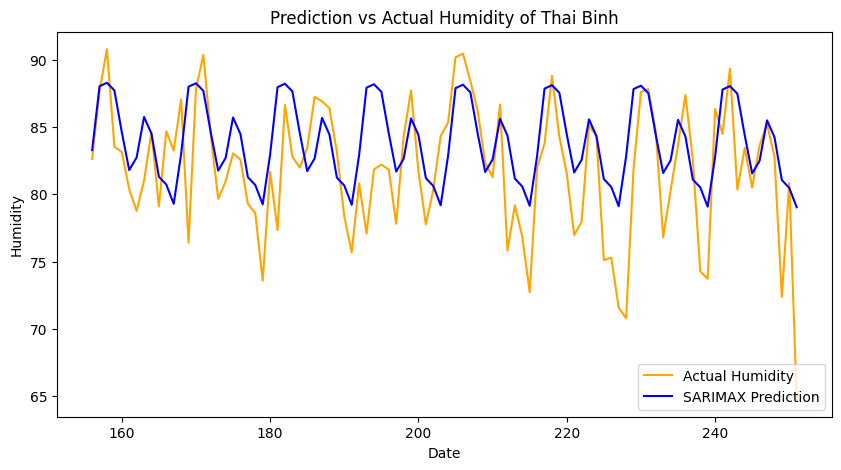

Results for Humidity saved to humidity_SARIMAX_predictions.csv

Fitting One-Step-Ahead SARIMAX Model for Precip:


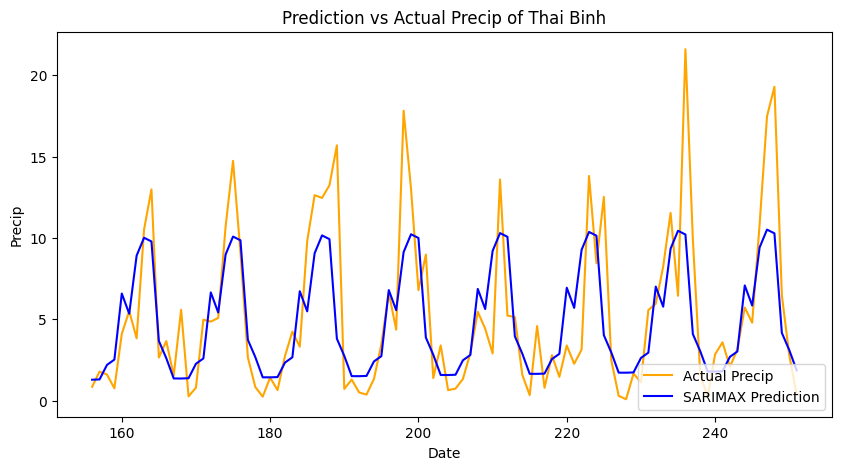

Results for Precip saved to precip_SARIMAX_predictions.csv

Temperature Results:
        Date  Actual_Temperature  Predicted_Temperature
0 2015-01-31           17.767742              16.455253
1 2015-02-28           19.025000              18.538437
2 2015-03-31           22.041935              20.420094
3 2015-04-30           24.573333              24.231327
4 2015-05-31           29.519355              27.526663

Humidity Results:
        Date  Actual_Humidity  Predicted_Humidity
0 2015-01-31        82.638710           83.284479
1 2015-02-28        87.692857           88.035124
2 2015-03-31        90.783871           88.289214
3 2015-04-30        83.543333           87.725517
4 2015-05-31        83.148387           84.626518

Precip Results:
        Date  Actual_Precip  Predicted_Precip
0 2015-01-31       0.853129          1.285070
1 2015-02-28       1.783107          1.304611
2 2015-03-31       1.600774          2.194185
3 2015-04-30       0.758533          2.520086
4 2015-05-31     

In [22]:
# Create an empty dictionary to store result DataFrames for each feature
results = {}
best_params = {
    'temperature': {'order': (1, 1, 2), 'seasonal_order': (0, 1, 1, 12)},
    'humidity': {'order': (0, 1, 2), 'seasonal_order': (0, 1, 1, 12)},
    'precip': {'order': (0, 1, 2), 'seasonal_order': (0, 1, 1, 12)}
}
# Loop through each feature for one-step-ahead prediction
for feature in features_to_model:
    print(f"\nFitting One-Step-Ahead SARIMAX Model for {feature.capitalize()}:")

    one_step_predictions = []
    order = best_params[feature]['order']
    seasonal_order = best_params[feature]['seasonal_order']
    # Make 96 one-step-ahead predictions iteratively
    for i in range(96):
        cut_point = weather[feature].size - 96 + i

        # Define the SARIMAX model
        model = sm.tsa.statespace.SARIMAX(
            train_data_SARIMA[feature][:cut_point],  # Use partial data
            order=order,                             # Feature-specific (p, d, q)
            seasonal_order=seasonal_order,           # Feature-specific (P, D, Q, m)
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        # Fit the model and predict the next value
        result = model.fit(disp=False)
        one_step_predictions.append(result.predict(cut_point).values[0])

    # Step 4: Store predictions in the test DataFrame
    test_data_SARIMA[f'{feature}_prediction'] = one_step_predictions

    # Plot Actual vs Predicted values for the feature
    plt.figure(figsize=(10, 5))
    test_data_SARIMA[feature].plot(label=f'Actual {feature.capitalize()}', color='orange')
    test_data_SARIMA[f'{feature}_prediction'].plot(label=f'SARIMAX Prediction', color='blue')

    plt.title(f"Prediction vs Actual {feature.capitalize()} of Thai Binh")
    plt.xlabel('Date')
    plt.ylabel(f'{feature.capitalize()}')
    plt.legend(loc='lower right')
    plt.show()

    # Step 5: Save predictions in a new DataFrame
    df_results = test_data_SARIMA[['date', feature, f'{feature}_prediction']].reset_index(drop=True)
    df_results.columns = ['Date', f'Actual_{feature.capitalize()}', f'Predicted_{feature.capitalize()}']

    # Store the results DataFrame in the dictionary
    results[feature] = df_results

    # Export the results to a CSV file
    csv_filename = f'{feature}_SARIMAX_predictions.csv'
    df_results.to_csv(csv_filename, index=False)
    print(f"Results for {feature.capitalize()} saved to {csv_filename}")

# Print the first few rows of the results for each feature
for feature, df in results.items():
    print(f"\n{feature.capitalize()} Results:")
    print(df.head())


In [23]:
test_data_SARIMA

,date,temperature,humidity,precip,temperature_prediction,humidity_prediction,precip_prediction
156,2015-01-31,17.767742,82.638710,0.853129,16.455253,83.284479,1.285070
157,2015-02-28,19.025000,87.692857,1.783107,18.538437,88.035124,1.304611
158,2015-03-31,22.041935,90.783871,1.600774,20.420094,88.289214,2.194185
159,2015-04-30,24.573333,83.543333,0.758533,24.231327,87.725517,2.520086
160,2015-05-31,29.519355,83.148387,4.099194,27.526663,84.626518,6.580353
...,...,...,...,...,...,...,...
247,2022-08-31,29.225806,85.238710,17.471290,28.576146,85.498306,10.510450
248,2022-09-30,28.510000,82.823333,19.287233,27.649355,84.259699,10.281099
249,2022-10-31,25.545161,72.370968,6.485871,25.677940,81.059754,4.164579
250,2022-11-30,25.326667,80.836667,2.791533,22.453432,80.474762,3.106532


# 2. Crop yield predictions

In [24]:
# Load crop data
crop_data = pd.read_excel('ThaiBinh.xlsx')
crop_data.columns = ['Year', 'Full_year_yield', 'Full_year_production', 'Winter_Spring_yield', 'Winter_Spring_production', 'Summer_yield', 'Summer_production']
crop_data_cleaned = crop_data.drop(0)
crop_data_cleaned['Year'] = pd.to_numeric(crop_data_cleaned['Year'])
crop_data_cleaned = crop_data_cleaned.dropna()

In [25]:
# Selecting the 'Year' and 'Full_year_production' as key variables
key_data = crop_data_cleaned[['Year', 'Winter_Spring_yield', 'Summer_yield']].dropna()

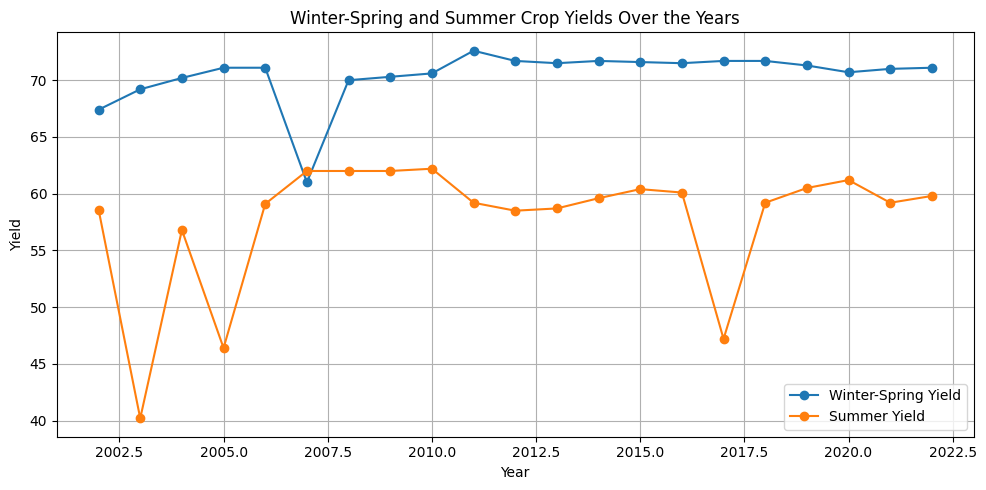

In [26]:
# Plotting Winter-Spring and Summer yields over the years
plt.figure(figsize=(10, 5))
plt.plot(key_data['Year'], key_data['Winter_Spring_yield'], label='Winter-Spring Yield', marker='o')
plt.plot(key_data['Year'], key_data['Summer_yield'], label='Summer Yield', marker='o')

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Yield')
plt.title('Winter-Spring and Summer Crop Yields Over the Years')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [27]:
import pandas as pd


# Step 1: Extract month for easy filtering
train_data_SARIMA['month'] = train_data_SARIMA['date'].dt.month

# Step 2: Define Winter and Summer months
winter_months = [1, 2, 3, 4, 5]  # January to May
summer_months = [5, 6, 7, 8, 9]  # May to September

# Step 3: Filter data for Winter and Summer seasons
train_winter_df = train_data_SARIMA[train_data_SARIMA['month'].isin(winter_months)].copy()
train_summer_df = train_data_SARIMA[train_data_SARIMA['month'].isin(summer_months)].copy()

# Drop the helper column 'month' if not needed in the separated data
train_winter_df.drop(columns=['month'], inplace=True)
train_summer_df.drop(columns=['month'], inplace=True)

# Display or process the separate DataFrames as needed
print("Winter DataFrame:")
print(train_winter_df.head())

print("\nSummer DataFrame:")
print(train_summer_df.head())




Winter DataFrame:
        date  temperature   humidity     precip
0 2002-01-31    15.700000  84.300000   0.076000
1 2002-02-28    18.650000  90.771429   0.981179
2 2002-03-31    21.761290  87.706452   0.721839
3 2002-04-30    25.320000  87.206667   1.597267
4 2002-05-31    27.393548  85.793548  11.371226

Summer DataFrame:
        date  temperature   humidity     precip
4 2002-05-31    27.393548  85.793548  11.371226
5 2002-06-30    29.496667  83.400000   4.510700
6 2002-07-31    29.258065  83.174194   4.325742
7 2002-08-31    28.200000  86.058065   5.740484
8 2002-09-30    27.103333  83.963333   2.621600


In [28]:
import pandas as pd


# Step 1: Extract month for easy filtering
test_data_SARIMA['month'] = test_data_SARIMA['date'].dt.month

# Step 2: Define Winter and Summer months
winter_months = [1, 2, 3, 4, 5]  # January to May
summer_months = [5, 6, 7, 8, 9]  # May to September

# Step 3: Filter data for Winter and Summer seasons
test_winter_df = test_data_SARIMA[test_data_SARIMA['month'].isin(winter_months)].copy()
test_summer_df = test_data_SARIMA[test_data_SARIMA['month'].isin(summer_months)].copy()

# Drop the helper column 'month' if not needed in the separated data
test_winter_df.drop(columns=['month'], inplace=True)
test_summer_df.drop(columns=['month'], inplace=True)

# Display or process the separate DataFrames as needed
print("Winter DataFrame:")
print(test_winter_df.head())

print("\nSummer DataFrame:")
print(test_summer_df.head())



Winter DataFrame:
          date  temperature   humidity    precip  temperature_prediction  \
156 2015-01-31    17.767742  82.638710  0.853129               16.455253   
157 2015-02-28    19.025000  87.692857  1.783107               18.538437   
158 2015-03-31    22.041935  90.783871  1.600774               20.420094   
159 2015-04-30    24.573333  83.543333  0.758533               24.231327   
160 2015-05-31    29.519355  83.148387  4.099194               27.526663   

     humidity_prediction  precip_prediction  
156            83.284479           1.285070  
157            88.035124           1.304611  
158            88.289214           2.194185  
159            87.725517           2.520086  
160            84.626518           6.580353  

Summer DataFrame:
          date  temperature   humidity     precip  temperature_prediction  \
160 2015-05-31    29.519355  83.148387   4.099194               27.526663   
161 2015-06-30    30.186667  80.370000   5.508900               29.479774   

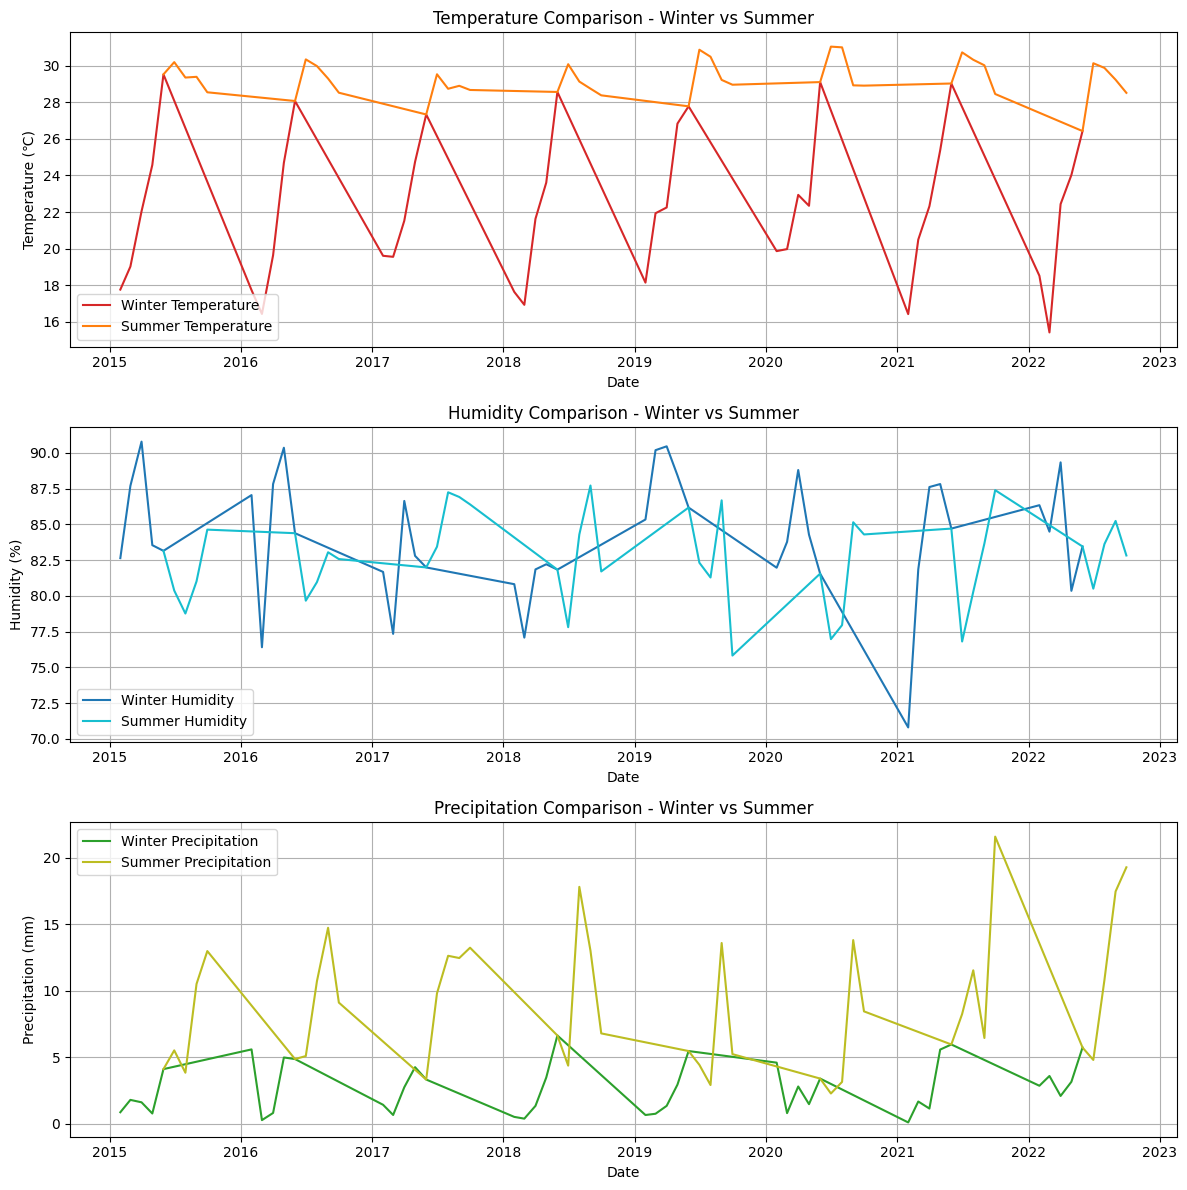

In [29]:
# Plotting separate subplots for each feature in Winter and Summer data
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# Temperature Plot
axs[0].plot(test_winter_df['date'], test_winter_df['temperature'], label='Winter Temperature', color='tab:red')
axs[0].plot(test_summer_df['date'], test_summer_df['temperature'], label='Summer Temperature', color='tab:orange')
axs[0].set_title("Temperature Comparison - Winter vs Summer")
axs[0].set_xlabel("Date")
axs[0].set_ylabel("Temperature (℃)")
axs[0].legend()
axs[0].grid(True)

# Humidity Plot
axs[1].plot(test_winter_df['date'], test_winter_df['humidity'], label='Winter Humidity', color='tab:blue')
axs[1].plot(test_summer_df['date'], test_summer_df['humidity'], label='Summer Humidity', color='tab:cyan')
axs[1].set_title("Humidity Comparison - Winter vs Summer")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("Humidity (%)")
axs[1].legend()
axs[1].grid(True)

# Precipitation Plot
axs[2].plot(test_winter_df['date'], test_winter_df['precip'], label='Winter Precipitation', color='tab:green')
axs[2].plot(test_summer_df['date'], test_summer_df['precip'], label='Summer Precipitation', color='tab:olive')
axs[2].set_title("Precipitation Comparison - Winter vs Summer")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Precipitation (mm)")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [30]:
train_summer_df['date'] = pd.to_datetime(train_summer_df['date'])
train_summer_df['Year'] = train_summer_df['date'].dt.year

train_winter_df['date'] = pd.to_datetime(train_winter_df['date'])
train_winter_df['Year'] = train_winter_df['date'].dt.year
test_summer_df['date'] = pd.to_datetime(test_summer_df['date'])
test_summer_df['Year'] = test_summer_df['date'].dt.year

test_winter_df['date'] = pd.to_datetime(test_winter_df['date'])
test_winter_df['Year'] = test_winter_df['date'].dt.year


In [31]:
train_summer_yearly = train_summer_df.groupby('Year').agg(
    temperature=('temperature', 'mean'),
    humidity=('humidity', 'mean'),
    precip=('precip', 'mean')
).reset_index()
train_winter_yearly = train_winter_df.groupby('Year').agg(
    temperature=('temperature', 'mean'),
    humidity=('humidity', 'mean'),
    precip=('precip', 'mean')
).reset_index()
test_summer_yearly = test_summer_df.groupby('Year').agg(
    temperature=('temperature', 'mean'),
    humidity=('humidity', 'mean'),
    precip=('precip', 'mean'),
    temperature_prediction=('temperature_prediction', 'mean'),
    humidity_prediction=('humidity_prediction', 'mean'),
    precip_prediction=('precip_prediction', 'mean')
).reset_index()
test_winter_yearly = test_winter_df.groupby('Year').agg(
    temperature=('temperature', 'mean'),
    humidity=('humidity', 'mean'),
    precip=('precip', 'mean'),
    temperature_prediction=('temperature_prediction', 'mean'),
    humidity_prediction=('humidity_prediction', 'mean'),
    precip_prediction=('precip_prediction', 'mean')
).reset_index()


In [32]:
# Combine both train and test weather forecasts into a single DataFrame
full_winter_data = pd.concat([
    train_winter_yearly[['Year', 'temperature', 'humidity', 'precip']],
    test_winter_yearly[['Year', 'temperature_prediction', 'humidity_prediction', 'precip_prediction']]
    .rename(columns={
        'temperature_prediction': 'temperature',
        'humidity_prediction': 'humidity',
        'precip_prediction': 'precip'
    })
], axis=0).reset_index(drop=True)

# Display the first few rows of the combined data
print(full_winter_data.head())


   Year  temperature   humidity    precip
0  2002    21.764968  87.155619  2.949502
1  2003    22.575003  86.089052  2.041749
2  2004    21.092876  85.538900  2.138452
3  2005    21.089257  85.852014  1.165871
4  2006    21.645534  84.940667  2.819989


In [33]:
# Combine both train and test weather forecasts into a single DataFrame
full_summer_data = pd.concat([
    train_summer_yearly[['Year', 'temperature', 'humidity', 'precip']],
    test_summer_yearly[['Year', 'temperature_prediction', 'humidity_prediction', 'precip_prediction']]
    .rename(columns={
        'temperature_prediction': 'temperature',
        'humidity_prediction': 'humidity',
        'precip_prediction': 'precip'
    })
], axis=0).reset_index(drop=True)

# Display the first few rows of the combined data
print(full_summer_data)


    Year  temperature   humidity    precip
0   2002    28.290323  84.477828  5.713950
1   2003    28.985548  84.032280  8.908562
2   2004    28.095978  83.599398  7.387069
3   2005    29.019484  82.189075  7.796665
4   2006    28.506023  81.205084  6.750928
5   2007    28.586387  81.316559  5.587662
6   2008    28.196065  84.087419  7.566794
7   2009    28.702845  83.129330  6.551195
8   2010    28.944301  83.280194  8.293793
9   2011    28.214452  83.268860  9.391179
10  2012    28.729957  83.373527  8.627389
11  2013    28.392559  83.980753  9.471098
12  2014    28.761935  84.453720  7.089118
13  2015    28.537464  83.884214  8.125486
14  2016    28.533075  83.848479  8.196870
15  2017    28.529430  83.812745  8.268253
16  2018    28.525793  83.777010  8.339637
17  2019    28.522157  83.741276  8.411021
18  2020    28.518521  83.705542  8.482405
19  2021    28.514885  83.669807  8.553788
20  2022    28.511248  83.634073  8.625172


In [34]:
# Merge weather data with crop production data
data_summer = pd.merge(
    crop_data_cleaned[['Year',  'Summer_yield']],
    full_summer_data,
    on='Year',
    how='inner'
)

In [35]:
data_summer

,Year,Summer_yield,temperature,humidity,precip
0,2002,58.6,28.290323,84.477828,5.713950
1,2003,40.2,28.985548,84.032280,8.908562
2,2004,56.8,28.095978,83.599398,7.387069
3,2005,46.4,29.019484,82.189075,7.796665
4,2006,59.1,28.506023,81.205084,6.750928
5,2007,62,28.586387,81.316559,5.587662
6,2008,62,28.196065,84.087419,7.566794
7,2009,62,28.702845,83.129330,6.551195
8,2010,62.2,28.944301,83.280194,8.293793
9,2011,59.2,28.214452,83.268860,9.391179


In [36]:
# Merge weather data with crop production data
data_winter = pd.merge(
    crop_data_cleaned[['Year',  'Winter_Spring_yield']],
    full_winter_data,
    on='Year',
    how='inner'
)

In [37]:
data_winter

,Year,Winter_Spring_yield,temperature,humidity,precip
0,2002,67.4,21.764968,87.155619,2.949502
1,2003,69.2,22.575003,86.089052,2.041749
2,2004,70.2,21.092876,85.538900,2.138452
3,2005,71.1,21.089257,85.852014,1.165871
4,2006,71.1,21.645534,84.940667,2.819989
5,2007,61,21.725985,83.866432,2.219844
6,2008,70,20.116224,83.877229,2.058906
7,2009,70.3,21.732229,85.713773,3.667257
8,2010,70.6,22.418533,85.607012,2.387570
9,2011,72.6,19.658942,84.190739,2.145425


In [38]:
# Scale the data (crop production and temperature)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_winter = scaler.fit_transform(data_winter[['Winter_Spring_yield','temperature','humidity',	'precip']])
scaled_data_summer = scaler.fit_transform(data_summer[['Summer_yield', 'temperature','humidity',	'precip']])

## 2.1 Random Forest




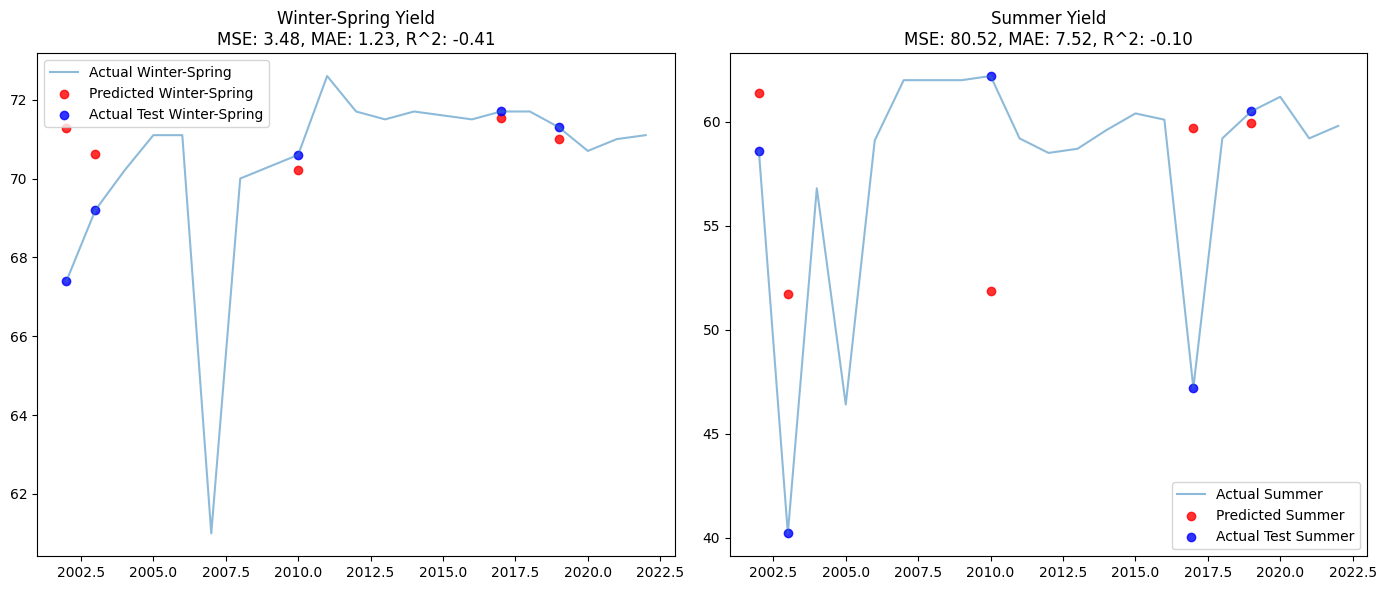

In [39]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Fit the random forest model and print evaluation metrics using a train-test split
def fit_and_evaluate(data, target_column):
    X = data.drop(columns=['Year', target_column])
    y = data[target_column]

    # Splitting data into train and test sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Making predictions on the test set
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    return model, mse, mae, r2, predictions, y_test, X_test.index

# Modeling for winter-spring season
model_ws, mse_ws, mae_ws, r2_ws, preds_ws, y_test_ws, idx_ws = fit_and_evaluate(data_winter, 'Winter_Spring_yield')

# Modeling for summer season
model_sum, mse_sum, mae_sum, r2_sum, preds_sum, y_test_sum, idx_sum = fit_and_evaluate(data_summer, 'Summer_yield')

# Visualization of results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(data_winter['Year'], data_winter['Winter_Spring_yield'], label='Actual Winter-Spring', alpha=0.5)
axs[0].scatter(data_winter.iloc[idx_ws]['Year'], preds_ws, color='red', label='Predicted Winter-Spring', alpha=0.8)
axs[0].scatter(data_winter.iloc[idx_ws]['Year'], y_test_ws, color='blue', label='Actual Test Winter-Spring', alpha=0.8)
axs[0].set_title(f'Winter-Spring Yield\nMSE: {mse_ws:.2f}, MAE: {mae_ws:.2f}, R^2: {r2_ws:.2f}')
axs[0].legend()

axs[1].plot(data_summer['Year'], data_summer['Summer_yield'], label='Actual Summer', alpha=0.5)
axs[1].scatter(data_summer.iloc[idx_sum]['Year'], preds_sum, color='red', label='Predicted Summer', alpha=0.8)
axs[1].scatter(data_summer.iloc[idx_sum]['Year'], y_test_sum, color='blue', label='Actual Test Summer', alpha=0.8)
axs[1].set_title(f'Summer Yield\nMSE: {mse_sum:.2f}, MAE: {mae_sum:.2f}, R^2: {r2_sum:.2f}')
axs[1].legend()

plt.tight_layout()
plt.show()


## 2.2 XGBoost Regressor

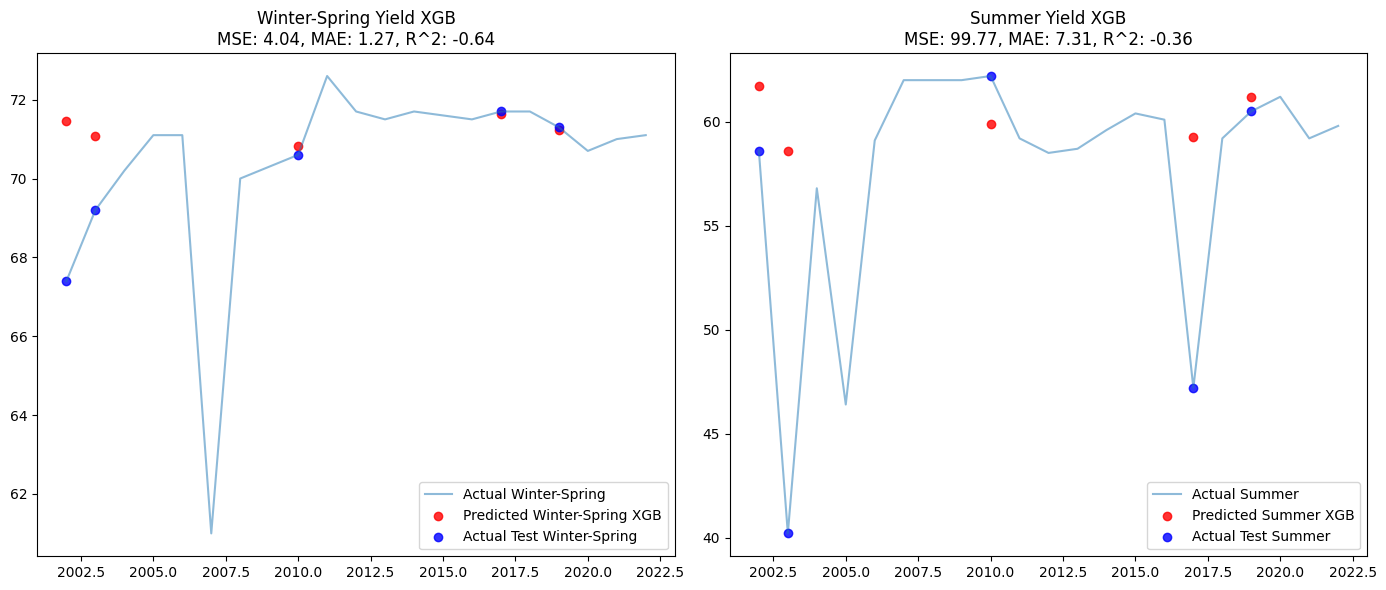

In [40]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Fit the XGBoost model with a train-test split and print evaluation metrics
def fit_and_evaluate_xgboost(data, target_column):
    X = data.drop(columns=['Year', target_column])
    y = data[target_column]

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = XGBRegressor(n_estimators=100, random_state=42, objective='reg:squarederror')
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    return model, mse, mae, r2, predictions, y_test, X_test.index

# Modeling for winter-spring season using XGBoost with train-test split
model_ws_xgb, mse_ws_xgb, mae_ws_xgb, r2_ws_xgb, preds_ws_xgb, y_test_ws, idx_ws = fit_and_evaluate_xgboost(data_winter, 'Winter_Spring_yield')

# Modeling for summer season using XGBoost with train-test split
model_sum_xgb, mse_sum_xgb, mae_sum_xgb, r2_sum_xgb, preds_sum_xgb, y_test_sum, idx_sum = fit_and_evaluate_xgboost(data_summer, 'Summer_yield')

# Visualization of results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot for winter-spring
axs[0].plot(data_winter['Year'], data_winter['Winter_Spring_yield'], label='Actual Winter-Spring', alpha=0.5)
axs[0].scatter(data_winter.iloc[idx_ws]['Year'], preds_ws_xgb, color='red', label='Predicted Winter-Spring XGB', alpha=0.8)
axs[0].scatter(data_winter.iloc[idx_ws]['Year'], y_test_ws, color='blue', label='Actual Test Winter-Spring', alpha=0.8)
axs[0].set_title(f'Winter-Spring Yield XGB\nMSE: {mse_ws_xgb:.2f}, MAE: {mae_ws_xgb:.2f}, R^2: {r2_ws_xgb:.2f}')
axs[0].legend()

# Plot for summer
axs[1].plot(data_summer['Year'], data_summer['Summer_yield'], label='Actual Summer', alpha=0.5)
axs[1].scatter(data_summer.iloc[idx_sum]['Year'], preds_sum_xgb, color='red', label='Predicted Summer XGB', alpha=0.8)
axs[1].scatter(data_summer.iloc[idx_sum]['Year'], y_test_sum, color='blue', label='Actual Test Summer', alpha=0.8)
axs[1].set_title(f'Summer Yield XGB\nMSE: {mse_sum_xgb:.2f}, MAE: {mae_sum_xgb:.2f}, R^2: {r2_sum_xgb:.2f}')
axs[1].legend()

plt.tight_layout()
plt.show()


##2.3 MLP Regressor (Neural Network)

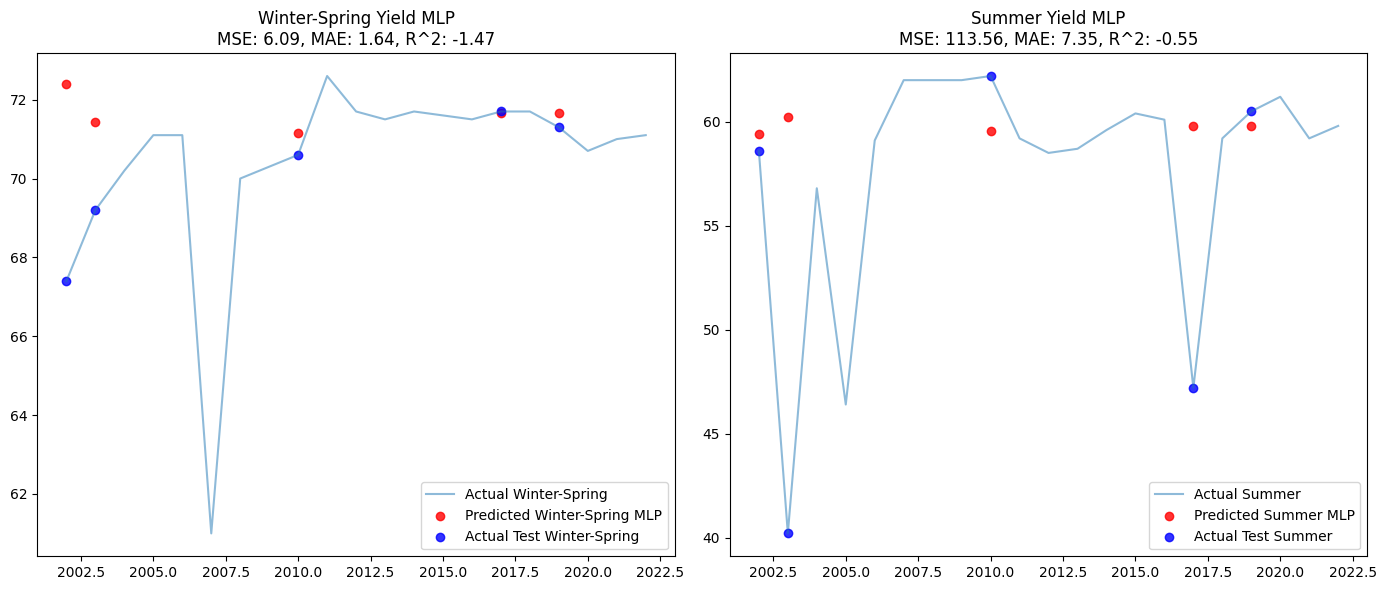

In [41]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Fit the MLPRegressor model with a train-test split and print evaluation metrics
def fit_and_evaluate_mlp(data, target_column):
    X = data.drop(columns=['Year', target_column])
    y = data[target_column]

    # Splitting data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Using a simple MLP architecture for quick training
    model = MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    return model, mse, mae, r2, predictions, y_test, X_test.index

# Modeling for winter-spring season using MLP with train-test split
model_ws_mlp, mse_ws_mlp, mae_ws_mlp, r2_ws_mlp, preds_ws_mlp, y_test_ws, idx_ws = fit_and_evaluate_mlp(data_winter, 'Winter_Spring_yield')

# Modeling for summer season using MLP with train-test split
model_sum_mlp, mse_sum_mlp, mae_sum_mlp, r2_sum_mlp, preds_sum_mlp, y_test_sum, idx_sum = fit_and_evaluate_mlp(data_summer, 'Summer_yield')

# Visualization of results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Winter-Spring results
axs[0].plot(data_winter['Year'], data_winter['Winter_Spring_yield'], label='Actual Winter-Spring', alpha=0.5)
axs[0].scatter(data_winter.iloc[idx_ws]['Year'], preds_ws_mlp, color='red', label='Predicted Winter-Spring MLP', alpha=0.8)
axs[0].scatter(data_winter.iloc[idx_ws]['Year'], y_test_ws, color='blue', label='Actual Test Winter-Spring', alpha=0.8)
axs[0].set_title(f'Winter-Spring Yield MLP\nMSE: {mse_ws_mlp:.2f}, MAE: {mae_ws_mlp:.2f}, R^2: {r2_ws_mlp:.2f}')
axs[0].legend()

# Summer results
axs[1].plot(data_summer['Year'], data_summer['Summer_yield'], label='Actual Summer', alpha=0.5)
axs[1].scatter(data_summer.iloc[idx_sum]['Year'], preds_sum_mlp, color='red', label='Predicted Summer MLP', alpha=0.8)
axs[1].scatter(data_summer.iloc[idx_sum]['Year'], y_test_sum, color='blue', label='Actual Test Summer', alpha=0.8)
axs[1].set_title(f'Summer Yield MLP\nMSE: {mse_sum_mlp:.2f}, MAE: {mae_sum_mlp:.2f}, R^2: {r2_sum_mlp:.2f}')
axs[1].legend()

plt.tight_layout()
plt.show()
